# A Simple Neural Network

In the previous notebook we said that training a neural network happens in two steps:

**Forward Propagation**: In forward prop, the NN makes its best guess about the correct output. It runs the input data through each of its functions to make this guess.

**Backward Propagation**: In backprop, the NN adjusts its parameters proportionate to the error in its guess. It does this by traversing backwards from the output, collecting the *derivatives* of the error with respect to the parameters of the functions (gradients), and uses this gradient to adjust its internal values.

In the previous notebook where we implemented the `Value` object, which is used to perform the backward propagation. In this notebook, we'll implement the forward pass for a single neuron and then for a full neural network. We'll then combine this with the backward propagation to train on a real dataset.

In [1]:
# To allow importing modules from the nnfs directory, can be ignored
import sys
import os

# Get the absolute path of the 'src' directory
src_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add 'src' directory to the Python path
if src_dir not in sys.path:
    sys.path.append(src_dir)

In [2]:
import random

import numpy as np
import matplotlib.pyplot as plt
# Must first download graphviz: https://graphviz.org/download/

from nnfs.helpers import draw_dot, np_array_to_list_of_values
from nnfs.autograd import Value

np.random.seed(42)
random.seed(42)

%matplotlib inline

## The Neuron

An artificial neuron is a fundamental building block of dense neural networks. It's inspired by biological neurons in the human brain, but is a simplified, mathematical model.

![An artificial neuron](img/neuron_model.png)

Here's a basic breakdown:

1. **Inputs**: The artificial neuron receives one or more inputs $x_i$. These could be raw data points, like pixels from an image, or outputs from other neurons.
2. **Weights**: Each input $x_i$ has an associated weight $w_i$, which can be adjusted over using backprop. Think of these weights as dials or knobs that can be turned to make the neuron behave differently. Each neuron also has a bias $b$, which is a baseline constant that can also be adjusted.
4. **Summation**: The neuron multiplies each input $x_i$ by its weight $w_i$, then sums up all these products, and adds the bias $b$. ($\sum_{i=1}^{n} w_i x_i + b$)
4. **Activation Function**: This sum then passes through an activation function $f$. The purpose of this function is to introduce non-linearity to the model, which allows neural networks to learn complex patterns. Common activation functions include the sigmoid, ReLU, and tanh.
5. **Output**: The result from the activation function is the output of the neuron, which can then serve as an input to another neuron in the next layer of a neural network.

In essence, the artificial neuron takes in data, processes it using its weights and the activation function, and then outputs a result.

#### Activation Function

In this notebook, we'll use the $\tanh$ as activation function, which is defined as:

$$\tanh(x) = \frac{e^{2x} - 1}{e^{2x} + 1}$$

$\tanh$, is a mathematical function that squishes the input values to and s-curve with values in the range (-1, 1).
It is useful as an activation function because it smooth, differential, and non-linear with values centered around zero, which are 
all properties that are useful for neural networks.

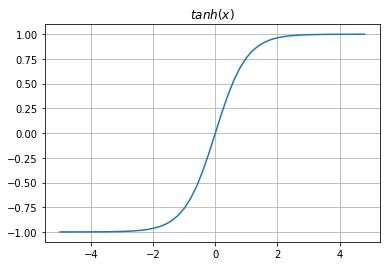

In [3]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()
plt.title('$tanh(x)$')
plt.show()

We'll now implement a neuron with two inputs using the `Value` object. We'll later convert this to a class so we can generalize it to neurons with any number of inputs and outputs.

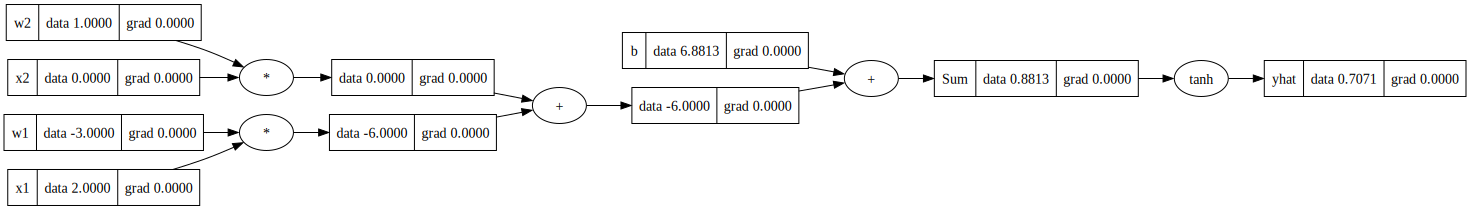

In [4]:
x = [Value(2.0, label='x1'), Value(0.0, label='x2')]  # inputs
w = [Value(-3.0, label='w1'), Value(1.0, label='w2')]  # weights
b = Value(6.8813, label='b')  # bias

# forward pass
f = x[0] * w[0] + x[1] * w[1] + b; f.label = 'Sum'  # Summation
yhat = f.tanh(); yhat.label = 'yhat'  # Activation function

draw_dot(yhat)

That's all there is to a forward pass of a single neuron: multiply inputs with weights, sum them up, add the bias, and pass them through an activation function. We can now easily generalize this to a neuron with any number of inputs and outputs.

In [5]:
class Neuron:
  
    def __init__(self, num_inputs, activation='tanh'):
        """Initialize the weights and bias randomly, and set the activation function"""
        self.w = [Value(random.uniform(-1,1), label=f'w_{i+1}') for i in range(num_inputs)]
        self.b = Value(random.uniform(-1,1), label='b')
        self.activation = activation
  
    def __call__(self, x):
        """The forward pass of a single neuron"""
        # Check that the number of inputs equals the number of weights
        if len(x) != len(self.w):
            raise ValueError(f'Expected {len(self.w)} inputs, got {len(x)}')
        
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)  # sum(w * x) + b
        if self.activation == 'tanh':
            out = act.tanh()
        elif self.activation == 'relu': # The ReLU activation equals to max(0, x)
            out = act.relu()
        else:  # The output of the neuron stays linear
            out = act
        return out
  
    def parameters(self):  
        """Return the weights and bias as a list"""
        return self.w + [self.b]
    
    def zero_grad(self):
        """Reset the gradients to zero"""
        for p in self.parameters():
            p.grad = 0
    
    def __repr__(self):
        if self.activation == 'tanh':
            neuron_type = 'Tanh'
        elif self.activation == 'relu':
            neuron_type = 'ReLU'
        else:
            neuron_type = 'Linear'
        return f'{neuron_type}Neuron({len(self.w)})'

We usually initialize the weights randomly. If all weights are initialized with the same value, every neuron in the hidden layer will produce the same output and undergo the same weight updates during training. This makes the neurons in that layer symmetric and redundant. Random initialization ensures that each neuron starts with a different weight and thus follows a unique gradient during training.

### Using `Neuron` to do linear regression

A single `Neuron` is able to do standard linear regression if we do not use an activation function. We'll generate a simple dataset $y=2 x_1+ 0.8x_2 + \epsilon$, where $x_i$ are the inputs, $\epsilon$ is a random noise term, and $y$ is the target. We'll use this dataset to demonstrate how to train a single neuron.

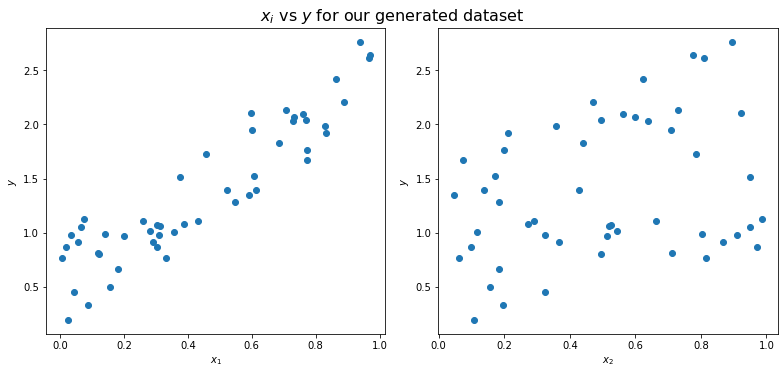

In [6]:
x = np.random.random((50, 2))
eps = np.random.random((50, )) * 0.2
y = 2 * x[:, 0] + 0.8 * x[:, 1] + eps

fig, axs = plt.subplots(1, 2, figsize=(11, 5))

axs[0].scatter(x[:,0], y, label='x1')
axs[0].set_xlabel('$x_1$')
axs[0].set_ylabel('$y$')

axs[1].scatter(x[:,1], y, label='x2')
axs[1].set_xlabel('$x_2$')
axs[1].set_ylabel('$y$')

fig.tight_layout()
fig.suptitle('$x_i$ vs $y$ for our generated dataset', y=1.03, fontsize=16)
plt.show()

To properly train our model we need a score to measure how well the model is doing. The goal of the model is to minimize this score during training. The score is called the loss (or cost) function in ML literature. In our linear regression example, we'll minimize the mean squared error (MSE), which is the default loss function for regression problems. The MSE is defined as
the average of the squared difference between the predicted and actual values. Or in mathematical notation:

$$MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$$

where $n$ is the number of samples, $y_i$ is the actual value, and $\hat{y}_i$ is the predicted value.

We'll start with minimizing the MSE for one iteration and for one sample to see to that everything works as expected. We'll then extend it to all samples in the dataset over multiple iterations to train our model.

In [7]:
def mse(y_true, y_pred):
    # Convert inputs to lists of values if they are scalars
    if not hasattr(y_true, '__iter__'):
        y_true = [y_true]
    if not hasattr(y_pred, '__iter__'):
        y_pred = [y_pred]
        
    num_items = len(y_true)
    return sum((y_i - pred_i)**2 for y_i, pred_i in zip(y_true, y_pred)) / num_items


linear_model = Neuron(num_inputs=2, activation='linear')  # num_inputs = number of features
linear_model

LinearNeuron(2)

In [8]:
# Forward pass
output = linear_model(x[0])
loss = mse(y[0], output)
loss

Value(7.6430, grad=0.0000)

The next step is to do the backwards pass. Since we're using the `Value` object we implemented in the last notebook, it will be very simple. Just call `.backward()` on the loss value and it will compute the derivative of the loss with respect to the weights.

The derivatives show how the loss will respond if we change the weights a tiny nudge. We can use this fact to adjust the weights in the direction that reduces the loss. We can demonstrate this with a simple image:

![Gradient Descent](img/gradient_descent.png)

In the image above, the current position is the loss of the model with the current weights. The derivative of the loss function with repsect to the weight gives slope of the loss function at the current position. We can use the slope to nudge the weights in the direction downwards so that the loss is reduced. Doing this iteratively will move the weights close to the bottom of the loss function, which is the point where the loss is minimized.

It should be noted that not all problems and loss functions have this smooth bowl shape. Most problems are much more complex and have many hills and valleys. This means that we can't just take a huge single step in the direction of the slope to get to the bottom. We need to take many smaller steps and each time find the new slope to reach the bottom of the valley. We can't know the slope of a point we haven't reached yet.

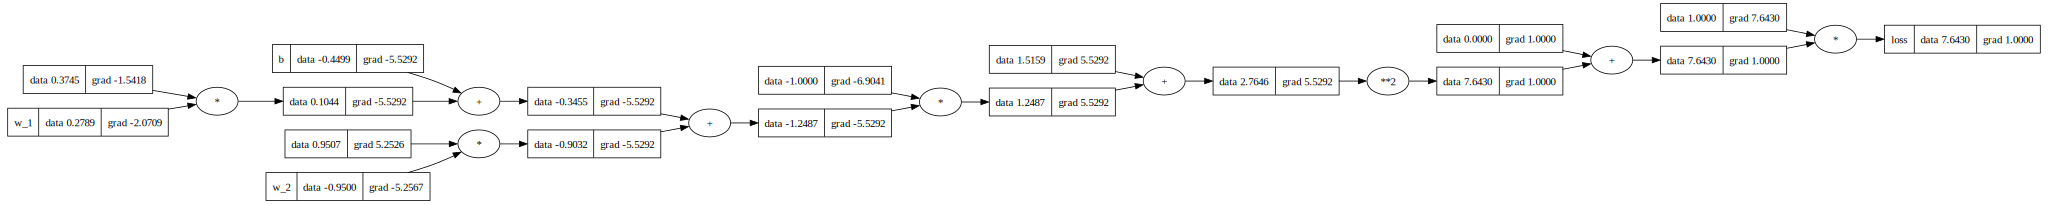

In [9]:
# Backward pass
loss.backward(); loss.label = 'loss'
draw_dot(loss)

Let's think through what direction we should be going if we want to decrease the loss. We can see that the gradients for the weights are $\frac{d_{loss}}{dw_1}=-2.07$, $\frac{d_{loss}}{dw_2}=-5.26$, and $\frac{d_{loss}}{db}=-5.53$, while $loss=7.64$. So if we want to decrease the loss, we need to increase the weights. This means moving in the opposite direction of the gradients (which is always the case).

The size of the movement is given by `learning_rate`, which is a value that often must be fine-tuned to get the best results. Too small of a learning rate will result in slow training, while too large of a learning rate will result in the model overshooting the optimal weights and never converging.

![learning_rate](img/learning_rate.jpg)

In [10]:
def update_weights(neuron, learning_rate=0.01):
    for parameter in neuron.parameters():
        parameter.data -= parameter.grad * learning_rate
    neuron.zero_grad()  # Reset the gradients to zero
    return neuron

In [11]:
# Weights before and after update
print(linear_model.w, linear_model.b)
linear_model = update_weights(linear_model, learning_rate=0.01)
print(linear_model.w, linear_model.b)

[Value(0.2789, grad=-2.0709, label=w_1), Value(-0.9500, grad=-5.2567, label=w_2)] Value(-0.4499, grad=-5.5292, label=b)
[Value(0.2996, grad=0.0000, label=w_1), Value(-0.8974, grad=0.0000, label=w_2)] Value(-0.3946, grad=0.0000, label=b)


Now, let's check if the loss has decreased after one iteration.

In [12]:
output = linear_model(x[0])
loss = mse(y[0], output)
loss  # Previous loss = 7.6430

Value(7.0308, grad=0.0000)

Success! We've moved the weights in a direction that lowers the loss. 

The proccess of iteratively moving the weights to reduce the loss is called gradient descent. The whole proccess of training a model with gradient descent can be summarized as follows:

1. Predict the output given the input data and current weights.
2. Compute the loss between the predicted and actual values.
3. Compute the gradient of the loss with respect to the weights.
4. Move the weights in the direction opposite to the gradient to reduce the loss.

We can now extend this to all samples over multiple iterations to train our linear model properly.

In [13]:
def train_model(model, num_iterations, learning_rate):
    # Trains the model with gradient descent
    for i in range(num_iterations):
        # Forward Pass
        ouputs = (model(xi) for xi in x)
        loss = mse(y, ouputs)
        # Backward Pass
        loss.backward()
        # Update
        update_weights(model, learning_rate=learning_rate)
        print(f'{i}: {loss.data:.4f}')

linear_model = Neuron(num_inputs=2, activation='linear')  # reset the weights
train_model(linear_model, num_iterations=100, learning_rate=0.5)

0: 1.6482
1: 0.6424
2: 0.3794
3: 0.2864
4: 0.2365
5: 0.2006
6: 0.1717
7: 0.1476
8: 0.1272
9: 0.1099
10: 0.0952
11: 0.0826
12: 0.0720
13: 0.0628
14: 0.0550
15: 0.0482
16: 0.0425
17: 0.0375
18: 0.0332
19: 0.0295
20: 0.0262
21: 0.0234
22: 0.0210
23: 0.0189
24: 0.0170
25: 0.0154
26: 0.0140
27: 0.0128
28: 0.0117
29: 0.0107
30: 0.0099
31: 0.0091
32: 0.0085
33: 0.0079
34: 0.0074
35: 0.0069
36: 0.0065
37: 0.0062
38: 0.0059
39: 0.0056
40: 0.0054
41: 0.0051
42: 0.0049
43: 0.0048
44: 0.0046
45: 0.0045
46: 0.0044
47: 0.0043
48: 0.0042
49: 0.0041
50: 0.0040
51: 0.0039
52: 0.0039
53: 0.0038
54: 0.0038
55: 0.0037
56: 0.0037
57: 0.0036
58: 0.0036
59: 0.0036
60: 0.0036
61: 0.0035
62: 0.0035
63: 0.0035
64: 0.0035
65: 0.0035
66: 0.0035
67: 0.0034
68: 0.0034
69: 0.0034
70: 0.0034
71: 0.0034
72: 0.0034
73: 0.0034
74: 0.0034
75: 0.0034
76: 0.0034
77: 0.0034
78: 0.0034
79: 0.0034
80: 0.0034
81: 0.0034
82: 0.0034
83: 0.0034
84: 0.0034
85: 0.0034
86: 0.0034
87: 0.0034
88: 0.0034
89: 0.0034
90: 0.0034
91: 0.003

In [14]:
linear_model.parameters()

[Value(2.0056, grad=0.0000, label=w_1),
 Value(0.8337, grad=0.0000, label=w_2),
 Value(0.0766, grad=0.0000, label=b)]

Our linear neuron works. It predicts the relationship to be $\hat{y}=2.0056x_1+0.8337x_2+0.0766+\epsilon$, which is pretty close to the true relationship $y=2x_1+0.8x_2+\epsilon$.

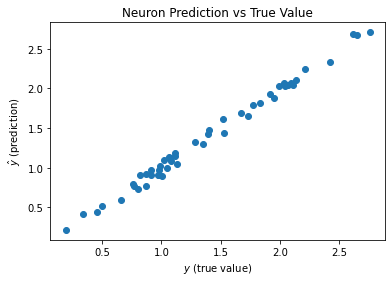

In [15]:
y_pred = [linear_model(xi).data for xi in x]

# plot scatter of y vs y_pred
plt.scatter(y, y_pred)
plt.xlabel('$y$ (true value)')
plt.ylabel('$\hat{y}$ (prediction)')
plt.title('Neuron Prediction vs True Value')
plt.show()

We can now move on to connecting together multiple (non-linear) neurons to form a neural network.

## Neural Network

A neural network is a collection of artificial neurons, grouped into layers. 
Within each layer, neurons operate independently as they are not interconnected. However, each neuron connects to every other neuron in the layer before and after. You can see an illustration of a neural network below.

![A neural network](img/neural_network.jpg)

Here's a basic breakdown:

- **Input Layer**: The first "layer" of the network is the raw input data, and not artificial neurons. The number of items in this layer is the number of input features.
- **Hidden Layers**: After the input layer, we have the "hidden" layer(s). These layers take the output of the previous layer, processes and transforms it using artificial neurons. We can stack many of these layers where the output of the neurons one layer is the input of the neurons in the next layer. Each neuron in this layer is connected to every neuron in the previous and next layer.
- **Output Layer**: This is the final layer, which produces the result. The activation function used in the output layer differs from the hidden layers and depends on the task at hand. For example, in a binary classification task, the output layer might have a [sigmoid activation function](https://en.wikipedia.org/wiki/Logistic_function) which squishes the output between 0 and 1 to represent the probability of belonging to the positive class.
- **Weights**: Each connection between neurons has a weight, which determines the strength of the connection. During training, the weights are adjusted to optimize the network's performance using backpropagation.

As with the neuron, we'll first implement a hard-coded neural network before generalizing.

 We'll create the network which was illustrated above. It consists of an input layer with three features, two hidden layers with four neurons each, and an output layer with a single neuron. We'll use the $\tanh$ activation function for the hidden layers. We will pretend that we do a regression task so we'll use a linear activation function for the output layer.

In [16]:
x = [Value(2.0, label='x_1'), Value(0.0, label='x_2'), Value(-3.0, label='x_3')]  # inputs
y = [Value(1.0, label='y')]  # outputs

hidden_layer1 = [Neuron(3), Neuron(3), Neuron(3), Neuron(3)]  # Uses tanh activation by default
hidden_layer2 = [Neuron(4), Neuron(4), Neuron(4), Neuron(4)]
output_layer = Neuron(4, activation='linear')

The procedure for training a network is very similar to that of a single neuron. We'll use the same MSE loss function and gradient descent algorithm as before. Remember that the proccess of training a model is as follows: 

1. Predict the output given the input data and current weights.
2. Compute the loss between the predicted and actual values.
3. Compute the gradient of the loss with respect to the weights.
4. Move the weights in the direction opposite to the gradient to reduce the loss.

We start with the forward pass of the network. It is done by passing the outputs of one layer to the next, until we reach the last layer which gives us the output of the network.

In [17]:
# Forward pass

# First hidden layer
a_1 = [neuron(x) for neuron in hidden_layer1]
# Second hidden layer
a_2 = [neuron(a_1) for neuron in hidden_layer2]  # The input is the output of the first hidden layer
# Output layer
yhat = output_layer(a_2)  # The input is the output of the second hidden layer
yhat

Value(-1.3343, grad=0.0000)

In [18]:
loss = mse(y, yhat)
loss

Value(5.4491, grad=0.0000)

As with the single neuron, the backward pass is as simple ass calling `.backward()` on the loss value to compute the gradients of the model.

In [19]:
# backward pass
loss.backward()

The last step is to update our weights using the gradients from the previous step.

In [20]:
# Updating the parameters
def update_weights(model, learning_rate=0.01):  # Redefined here for your convenience
    for parameter in model.parameters():
        parameter.data -= parameter.grad * learning_rate
    model.zero_grad()  # Reset the gradients to zero

LR = 0.01

update_weights(output_layer, LR)
for neuron in hidden_layer2:
    update_weights(neuron, LR)
for neuron in hidden_layer1:
    update_weights(neuron, LR)

We can now check that the proccess works by redoing the forward pass.

In [21]:
# Forward pass
a_1 = [neuron(x) for neuron in hidden_layer1]
a_2 = [neuron(a_1) for neuron in hidden_layer2]
yhat = output_layer(a_2)
loss = mse(y, yhat)
print(loss)  # Previous loss = 5.4491

Value(4.1383, grad=0.0000)


Success again! We'll now generalize what we just did by creating two new classes `Layer` and `VanillaNN`. We'll start with `Layer`.

The `Layer` class is simple. It is just a list of neurons, the number of which is defined by `num_ouputs`, each taking
`num_inputs` of features as inputs. The rest of the interface is the same as in `Neuron`.

In [22]:
class Layer:
    def __init__(self, num_inputs, num_outputs, activation='tanh'):
        self.neurons = [Neuron(num_inputs, activation) for _ in range(num_outputs)]

    def __call__(self, x):
        """The forward pass of a single layer"""
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        """Return the weights and bias of the whole layer as a list"""
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer({self.neurons})"
    
    def zero_grad(self):
        """Reset the gradients to zero"""
        for p in self.parameters():
            p.grad = 0

layer = Layer(3, 4, activation='relu')
print(layer)

Layer([ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3)])


`VanillaNN` is also just as simple. It is just a list of `Layer`'s. The simplicity of `Layer` and `VanillaNN` testifies to how much of the real work is already implemented by `Value` and `Neuron`.

In [23]:
class VanillaNN:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        """The forward pass of a full network"""
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        """Return the weights and bias of the whole network as a list"""
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        layers_str = ',\n  '.join([str(layer) for layer in self.layers])
        return f"VanillaNN([\n  {layers_str}\n])"

    def zero_grad(self):
        """Reset the gradients to zero"""
        for p in self.parameters():
            p.grad = 0

layers = [
    Layer(3, 4, activation='tanh'),
    Layer(4, 4, activation='tanh'),
    Layer(4, 1, activation='linear')
]
nn = VanillaNN(layers)
nn

VanillaNN([
  Layer([TanhNeuron(3), TanhNeuron(3), TanhNeuron(3), TanhNeuron(3)]),
  Layer([TanhNeuron(4), TanhNeuron(4), TanhNeuron(4), TanhNeuron(4)]),
  Layer([LinearNeuron(4)])
])

We can do a sanity check of our network by implementing a training loop on the same data used above.

In [24]:
print(f'Actual Value: {y[0].data}')
print(f'Prediction before training: {nn(x).data:.4f}\n')
for _ in range(5):
    yhat = nn(x)
    loss = mse(y, yhat)
    print(f'{loss.data=:0.4f}')
    loss.backward()
    update_weights(nn, learning_rate=0.05)
    
print(f'\nPrediction after training: {nn(x).data:.4f}')

Actual Value: 1.0
Prediction before training: 0.5425

loss.data=0.2093
loss.data=0.0335
loss.data=0.0051
loss.data=0.0008
loss.data=0.0001

Prediction after training: 0.9959


Now, training on a fake "dataset" consisting of one single datapoint isn't exactly interesting, realistic, nor really in the spirit of deep learning. So let's try to train our network on something more akin to a real dataset.

## Training on a real dataset